In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from itertools import combinations, permutations
from time import time
import pandas as pd
from numpy.random import random
import warnings
warnings.filterwarnings('ignore')
from scipy.misc import comb
from scipy import stats
from scipy.spatial import distance
from agg_util import *
from fare.metrics import *
import seaborn as sns
from ir_metrics import *
import fairsearchcore as fsc
from yang_metrics import *
from dataGenerator import generateUnfairRanking

In [5]:
# p = 0.5 -> random, fair
# p large -> unfairly favors g1
# minority group is 0
def gen_minority_group_idx(n, p, ratio):
    len1 = int(n*ratio)
    len0 = n - len1
    idxs = []
    n=0 #count the items in the minority group
    i=0
    while len1 > 0 and len0 >0:
        if random() < p: 
            len1 -= 1
        else:
            idxs.append(i)
            len0 -= 1
            n += 1
        i += 1
    while len1 > 0:
        len1 -= 1
        i += 1
    while len0 >0:
        idxs.append(i)
        len0 -= 1
        n += 1
        i+=1
    return idxs,n

In [6]:
# get Yang + stoyanavich metrics
# https://github.com/DataResponsibly/FairRank/blob/master/demo_measures.md

# Step 1: Specify the input population with size of user and protected group
def get_yang_metric(ranks, group, cut, p, r):

#   method uses sliding window-like approach. this sets size of window
    cut_point = cut #int(len(ranks[0])/2) # the cut point of computation of fairness measures
    ms =[]
#     pro_N = len(group)
    for y_pred in ranks:
        fair_rKL = calculateNDFairness(y_pred,group,cut_point,KL_DIVERGENCE,max_rKL)
        fair_rND = calculateNDFairness(y_pred,group,cut_point,ND_DIFFERENCE,max_rND)
        fair_rRD = calculateNDFairness(y_pred,group,cut_point,RD_DIFFERENCE,max_rRD)
        
        fair_Rpar = calculateNDFairness(y_pred,group,cut_point,RPAR,max_rpar)
        fair_Rpar0 = calculateNDFairness(y_pred,group,cut_point,RPAR0,max_rpar0)
        fair_Rpar1 = calculateNDFairness(y_pred,group,cut_point,RPAR1,max_rpar1)
        
        fair_Skew = calculateNDFairness(y_pred,group,cut_point,SKEW,max_skew)
        fair_MinSkew = calculateNDFairness(y_pred,group,cut_point,MINSKEW,max_minskew)
        fair_MaxSkew = calculateNDFairness(y_pred,group,cut_point,MAXSKEW,max_maxskew)
        
#         to test Rpar on entire ranking
#         groups = [0 if x in group else 1 for x in y_pred ]
#         e0,e1 = rank_parity(y_pred,groups)
#         R_par = 1.0 - abs(e0 - e1) # reverse to match semantics of other metrics - large value -> more fair        
        
        ms.append([fair_rKL,fair_rND,fair_rRD,fair_Rpar,fair_Rpar0,fair_Rpar1,fair_Skew,fair_MaxSkew,fair_MinSkew])#,R_par])
    
    return pd.DataFrame(ms, columns=["fair_rKL","fair_rND","fair_rRD","fair_Rpar","fair_Rpar0","fair_Rpar1","fair_Skew","fair_MaxSkew","fair_MinSkew"]) #, "R_par"]) 

In [7]:
# random rankings
n_ranks =10
rank_len = 200

# make copy in format for fa_ir
ranks = []
for i in range(n_ranks):
    r = np.array(range(rank_len))
    np.random.shuffle(r)
    ranks.append(r)
    
np.shape(ranks)

(10, 200)

In [8]:
def plot_heatmap(df, filename):
    corr = df.corr()
    ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
#     plt.savefig(filename, bb_inches='tight')
    plt.show()

Unfairness:  0.5
Group Size:  0.5
0.5 0.5 10


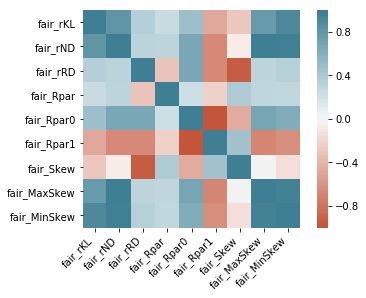

0.5 0.5 25


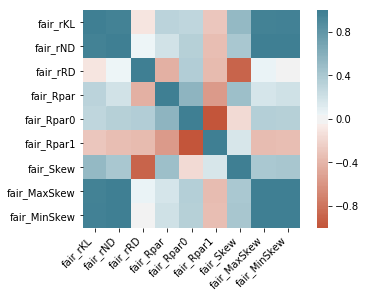

0.5 0.5 50


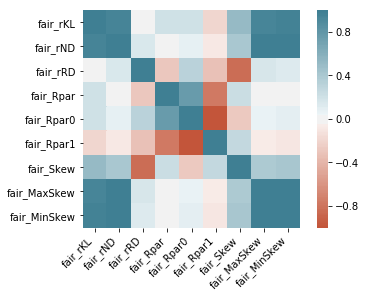

Group Size:  0.7
0.7 0.5 10


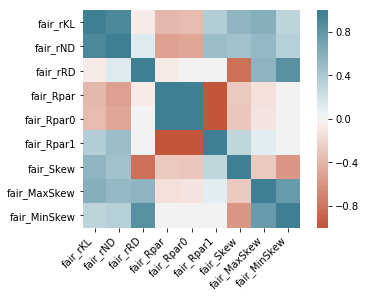

0.7 0.5 25


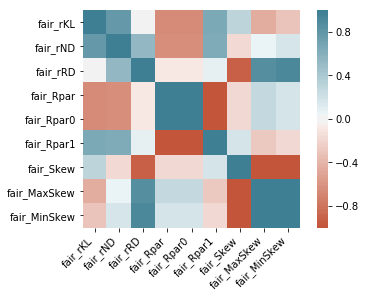

0.7 0.5 50


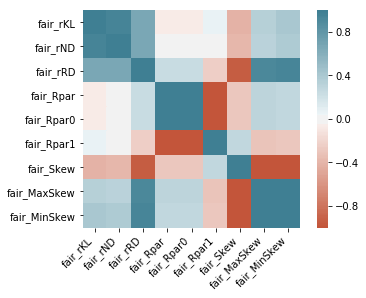

Group Size:  0.9
0.9 0.5 10


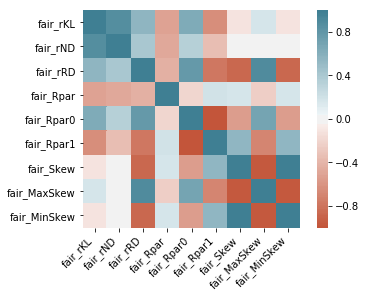

0.9 0.5 25


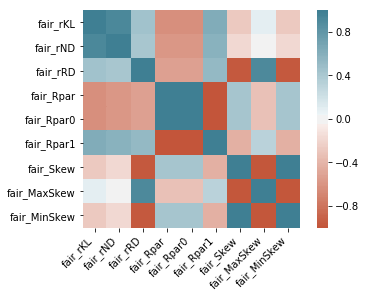

0.9 0.5 50


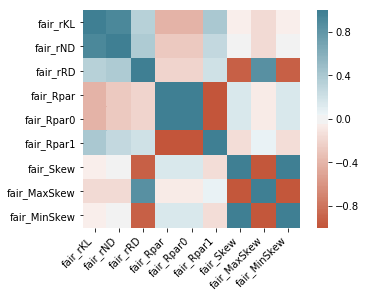

Unfairness:  0.7
Group Size:  0.5
0.5 0.7 10


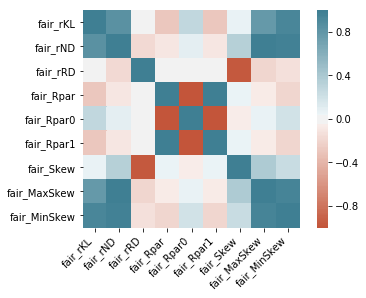

0.5 0.7 25


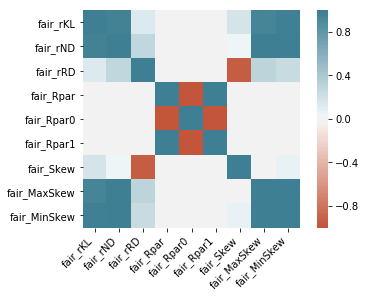

0.5 0.7 50


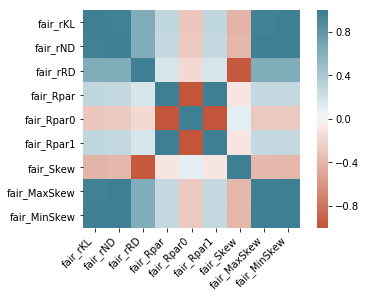

Group Size:  0.7
0.7 0.7 10


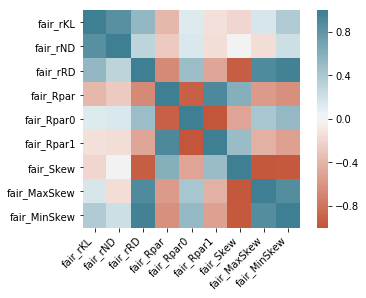

0.7 0.7 25


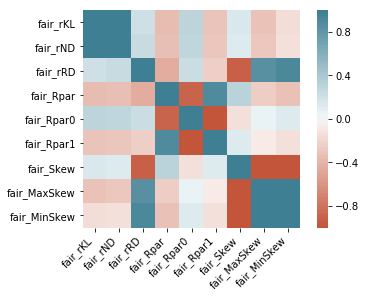

0.7 0.7 50


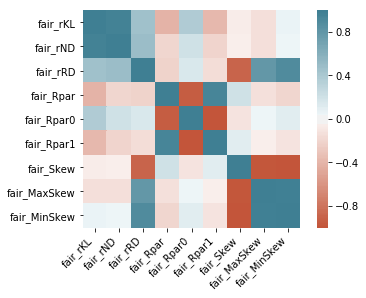

Group Size:  0.9
0.9 0.7 10


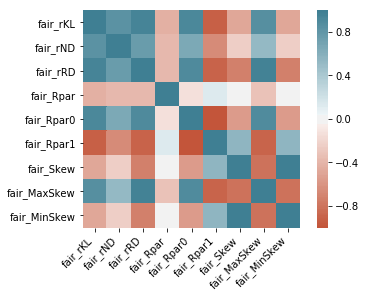

0.9 0.7 25


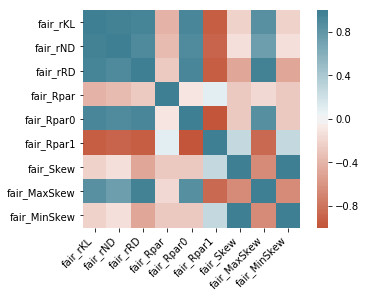

0.9 0.7 50


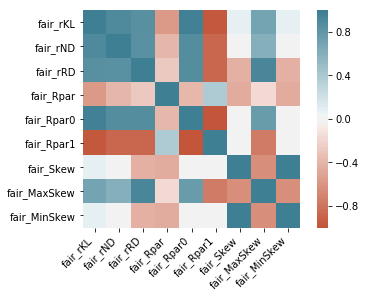

Unfairness:  0.9
Group Size:  0.5
0.5 0.9 10


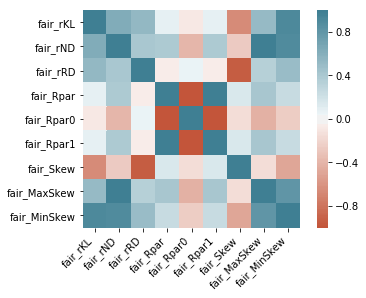

0.5 0.9 25


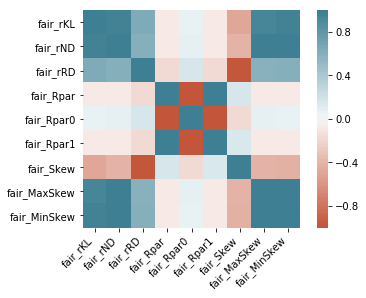

0.5 0.9 50


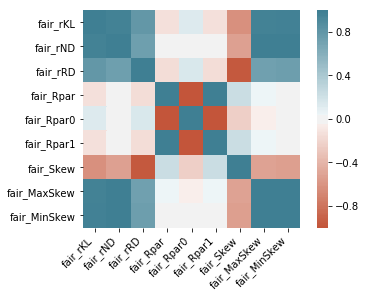

Group Size:  0.7
0.7 0.9 10


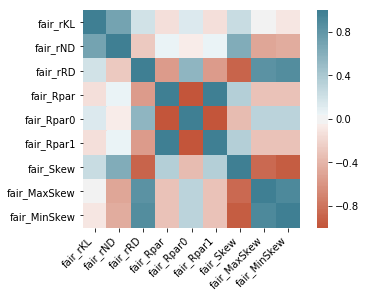

0.7 0.9 25


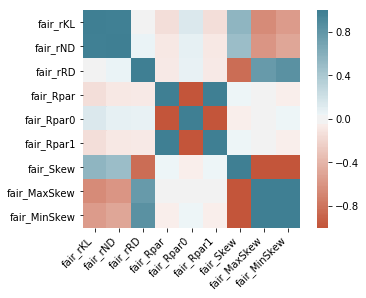

0.7 0.9 50


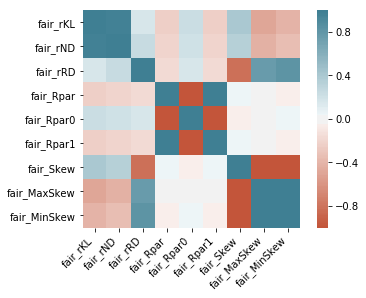

Group Size:  0.9
0.9 0.9 10


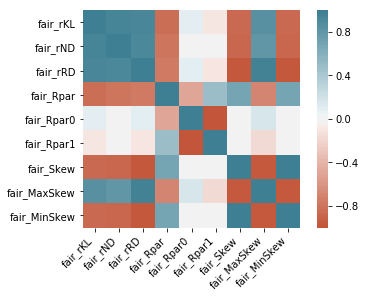

0.9 0.9 25


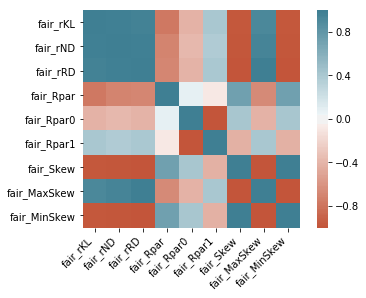

0.9 0.9 50


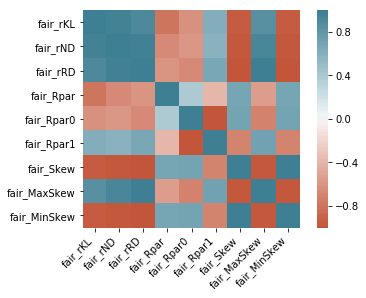

In [9]:
# normalized  
# if this input population has been computed, then get from recorded maximum (stored in normalizer.txt)      
# else compute the normalizer of input population
user_N = len(ranks[0])

for p in [0.5,0.7,0.9]:
    print("Unfairness: ",p)
    for r in [0.5, 0.7, 0.9]:
        print("Group Size: ", r)
        g,n = np.array(gen_minority_group_idx(len(ranks[0]), p, r))
        pro_N = n
        max_rKL = getNormalizer(user_N,pro_N,KL_DIVERGENCE)  
        max_rND = getNormalizer(user_N,pro_N,ND_DIFFERENCE)
        max_rRD = getNormalizer(user_N,pro_N,RD_DIFFERENCE)
        max_rpar = getNormalizer(user_N,pro_N,RPAR) 
        max_rpar0 = getNormalizer(user_N,pro_N,RPAR0)
        max_rpar1 = getNormalizer(user_N,pro_N,RPAR1)
        max_skew = getNormalizer(user_N,pro_N,SKEW)  
        max_minskew = getNormalizer(user_N,pro_N,MINSKEW)
        max_maxskew = getNormalizer(user_N,pro_N,MAXSKEW)
        for cut in [10, 25, 50]:
            ym = get_yang_metric(ranks, g, cut, p, r)
            print(r, p, cut)
#             plot_heatmap(ym, "charts/heatmap_norm.png")
            plot_heatmap(ym, "charts/heatmap_norm"+str(p)+"_"+str(r)+"_"+str(cut)+".png")

Unfairness:  0.5
Group Size:  0.5
0.5 0.5 10


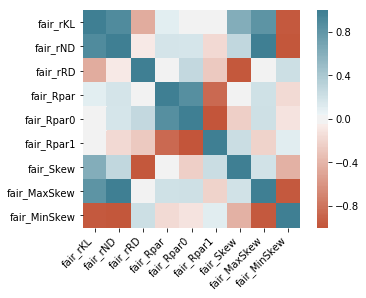

0.5 0.5 25


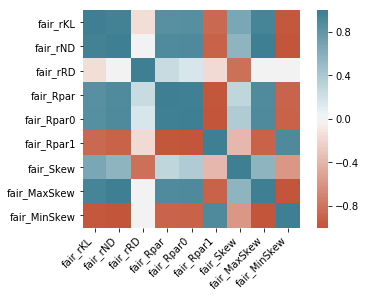

0.5 0.5 50


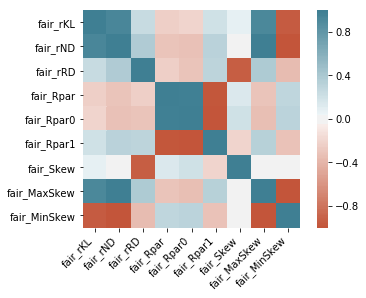

Group Size:  0.7
0.7 0.5 10


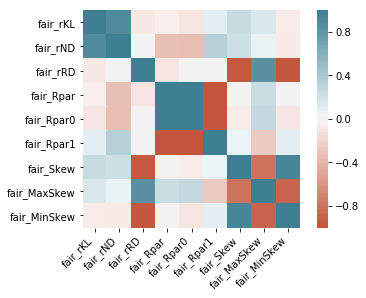

0.7 0.5 25


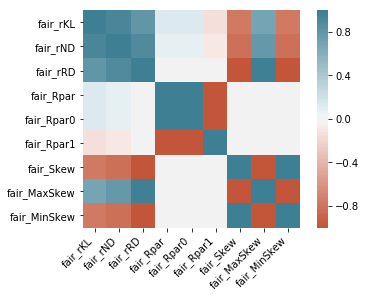

0.7 0.5 50


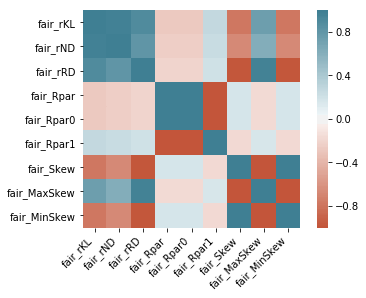

Group Size:  0.9
0.9 0.5 10


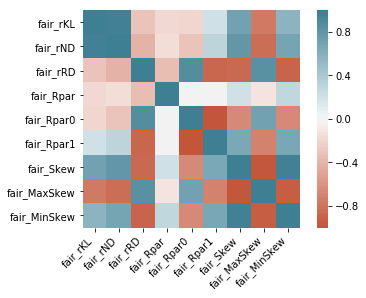

0.9 0.5 25


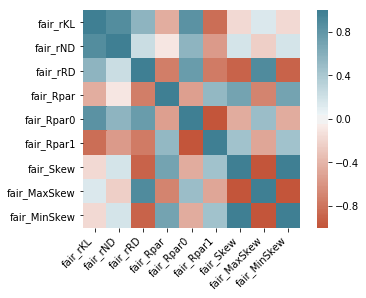

0.9 0.5 50


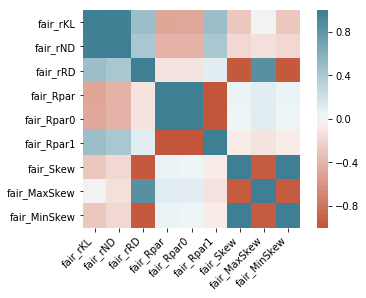

Unfairness:  0.7
Group Size:  0.5
0.5 0.7 10


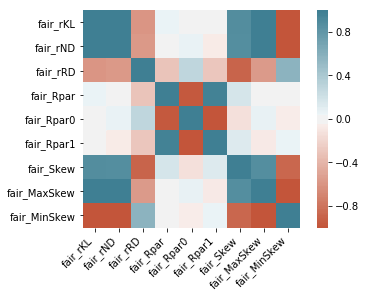

0.5 0.7 25


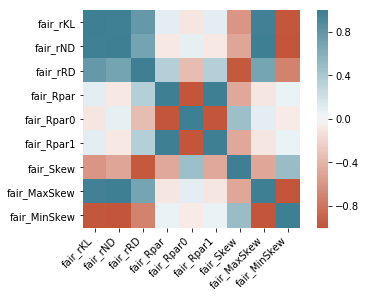

0.5 0.7 50


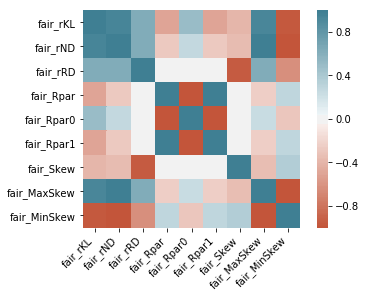

Group Size:  0.7
0.7 0.7 10


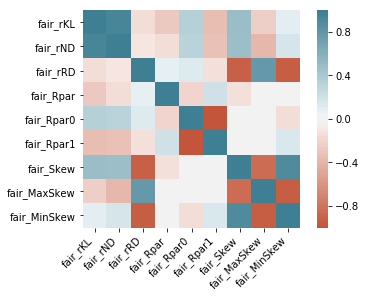

0.7 0.7 25


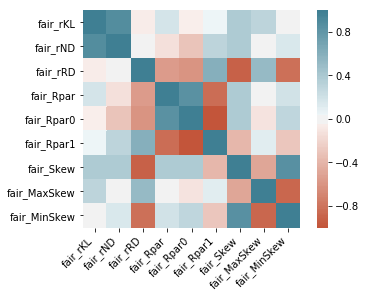

0.7 0.7 50


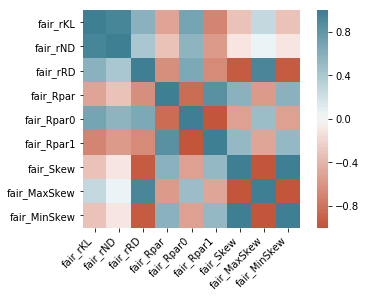

Group Size:  0.9
0.9 0.7 10


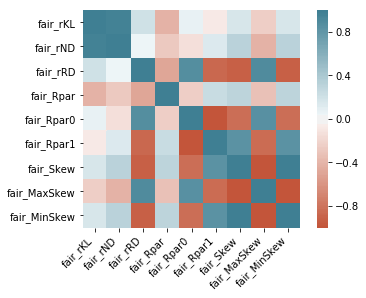

0.9 0.7 25


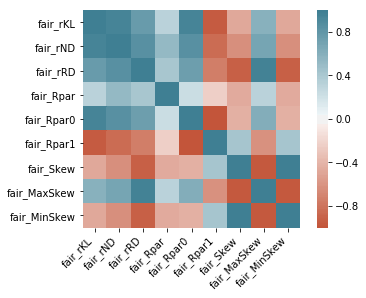

0.9 0.7 50


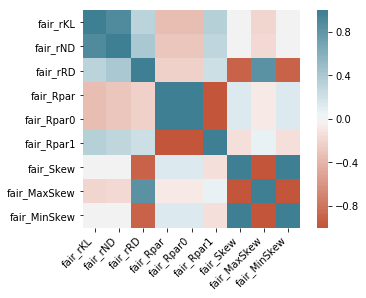

Unfairness:  0.9
Group Size:  0.5
0.5 0.9 10


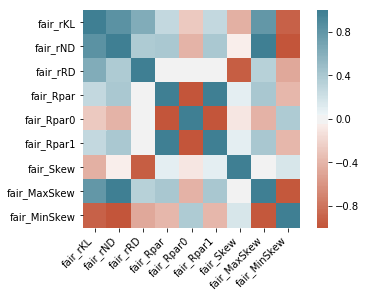

0.5 0.9 25


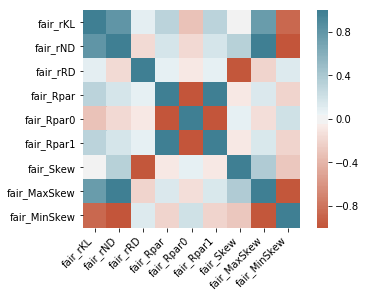

0.5 0.9 50


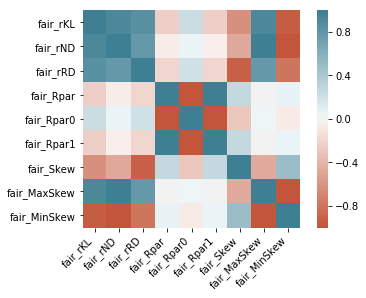

Group Size:  0.7
0.7 0.9 10


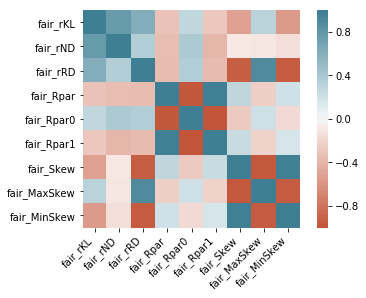

0.7 0.9 25


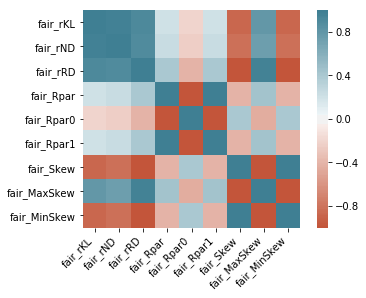

0.7 0.9 50


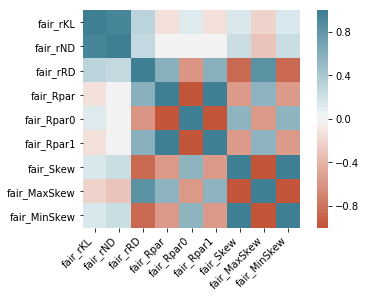

Group Size:  0.9
0.9 0.9 10


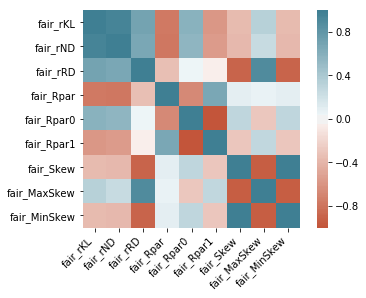

0.9 0.9 25


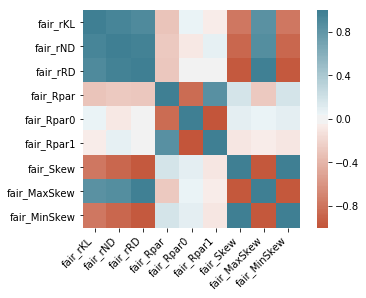

0.9 0.9 50


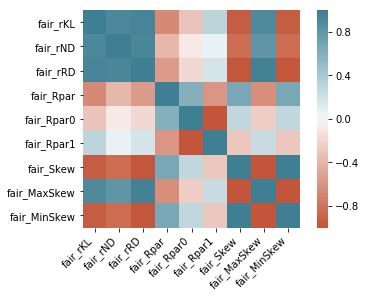

In [10]:
# non normalized
max_rKL = 1  
max_rND = 1
max_rRD = 1
max_rpar = 1  
max_rpar0 = 1
max_rpar1 = 1
max_skew = 1 
max_minskew = 1
max_maxskew = 1

for p in [0.5,0.7,0.9]:
    print("Unfairness: ",p)
    for r in [0.5, 0.7, 0.9]:
        print("Group Size: ", r)
        for cut in [10, 25, 50]:
            g,n = np.array(gen_minority_group_idx(len(ranks[0]), p, r))
            ym = get_yang_metric(ranks, g, cut, p, r)
            print(r, p, cut)
            plot_heatmap(ym, "charts/heatmap"+str(p)+"_"+str(r)+"_"+str(cut)+".png")

In [ ]:
# non normalized
max_rKL = 1  
max_rND = 1
max_rRD = 1
max_rpar = 1  
max_rpar0 = 1
max_rpar1 = 1
max_skew = 1 
max_minskew = 1
max_maxskew = 1

for p in [0.5,0.7,0.9]:
    print("Unfairness: ",p)
    for r in [0.5, 0.7, 0.9]:
        print("Group Size: ", r)
        for cut in [10, 25, 50]:
            g,n = np.array(gen_minority_group_idx(len(ranks[0]), p, r))
            ym = get_yang_metric(ranks, g, cut, p, r)
            print(r, p, cut)
            plot_heatmap(ym, "charts/heatmap"+str(p)+"_"+str(r)+"_"+str(cut)+".png")

In [14]:
# #non normalized
# max_rKL = 1  
# max_rND = 1
# max_rRD = 1
# max_rpar = 1  
# max_rpar0 = 1
# max_rpar1 = 1
# max_skew = 1 
# max_minskew = 1
# max_maxskew = 1

# for p in [0.5,0.7,0.9]:
#     for r in [0.5, 0.7, 0.9]:
#         for cut in [25]:
#             g,n = np.array(gen_minority_group_idx(len(ranks[0]), p, r))
#             ym = get_yang_metric(ranks, groups , cut, p, r)
#             print(r, p, cut)
#             ym.plot()
#             plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#             plt.savefig("charts/line"+str(p)+"_"+str(r)+"_"+str(cut)+".png", bb_inches='tight')
#             plt.show()
            
#             plt.clf()


Rank parity penalized the score whenever **either** group is given an unfair advantage. 

other metrics only penalize when the minority group is disadvantaged

In [22]:
# # normalized  
# # if this input population has been computed, then get from recorded maximum (stored in normalizer.txt)      
# # else compute the normalizer of input population
# user_N = len(ranks[0])

# for p in [0.5,0.7,0.9]:
#     print("Unfairness: ",p)
#     for r in [0.5, 0.7, 0.9]:
#         print("Group Size: ", r)
#         g,n = np.array(gen_minority_group_idx(len(ranks[0]), p, r))
#         pro_N = n
#         max_rKL = getNormalizer(user_N,pro_N,KL_DIVERGENCE)  
#         max_rND = getNormalizer(user_N,pro_N,ND_DIFFERENCE)
#         max_rRD = getNormalizer(user_N,pro_N,RD_DIFFERENCE)
#         max_rpar = getNormalizer(user_N,pro_N,RPAR)  
#         max_rpar0 = getNormalizer(user_N,pro_N,RPAR0)
#         max_rpar1 = getNormalizer(user_N,pro_N,RPAR1)
#         max_skew = getNormalizer(user_N,pro_N,SKEW)  
#         max_minskew = getNormalizer(user_N,pro_N,MINSKEW)
#         max_maxskew = getNormalizer(user_N,pro_N,MAXSKEW)
#         for cut in [10, 25, 50]:
#             ym = get_yang_metric(ranks, groups , cut, p, r)
#             print(r, p, cut)
#             ym.plot()
#             plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#             plt.savefig("charts/line_norm"+str(p)+"_"+str(r)+"_"+str(cut)+".png", bb_inches='tight')
#             plt.show()
            
#             plt.clf()

In [10]:
# get Yang + stoyanavich metrics
# https://github.com/DataResponsibly/FairRank/blob/master/demo_measures.md

KL_DIVERGENCE="rKL" # represent kl-divergence group fairness measure
ND_DIFFERENCE="rND" # represent normalized difference group fairness measure
RD_DIFFERENCE="rRD" # represent ratio difference group fairness measure
RPAR="rank parity" # fare 
LOG_BASE=2 # log base used in logorithm function

NORM_CUTPOINT=10 # cut-off point used in normalizer computation
NORM_ITERATION=10 # max iterations used in normalizer computation
NORM_FILE="normalizer.txt" # externally text file for normalizers
# Step 1: Specify the input population with size of user and protected group
user_N = 100 
pro_N = 50

 # normalized fairness follow here  
# if this input population has been computed, then get from recorded maximum (stored in normalizer.txt)      
# else compute the normalizer of input population
max_rKL = getNormalizer(user_N,pro_N,KL_DIVERGENCE)  
max_rND = getNormalizer(user_N,pro_N,ND_DIFFERENCE)
max_rRD = getNormalizer(user_N,pro_N,RD_DIFFERENCE)
max_rpar = getNormalizer(user_N,pro_N,RPAR)  
max_rpar0 = getNormalizer(user_N,pro_N,RPAR0)
max_rpar1 = getNormalizer(user_N,pro_N,RPAR1)
max_skew = getNormalizer(user_N,pro_N,SKEW)  
max_minskew = getNormalizer(user_N,pro_N,MINSKEW)
max_maxskew = getNormalizer(user_N,pro_N,MAXSKEW)

# non-normalized fairness ffor now 
max_rKL = 1
max_rND = 1
max_rRD = 1
test_ranking = [x for x in range(user_N)]
pro_index = [x for x in range(pro_N)]
cut_point = 10

fair_rKL = calculateNDFairness(test_ranking,pro_index,cut_point,KL_DIVERGENCE,max_rKL)
fair_rND = calculateNDFairness(test_ranking,pro_index,cut_point,ND_DIFFERENCE,max_rND)
fair_rRD = calculateNDFairness(test_ranking,pro_index,cut_point,RD_DIFFERENCE,max_rRD)

fair_Rpar = calculateNDFairness(test_ranking,pro_index,cut_point,RPAR,max_rRD)

print("rKL of test ranking is ", str(fair_rKL))
print("rND of test ranking is ", str(fair_rND))
print("rKL of test ranking is ", str(fair_rRD))
print("Rank Parity of test ranking is ", str(fair_Rpar)) #should remove normalization?

rKL of test ranking is  1.1590172403247105
rND of test ranking is  0.6600663344457944
rKL of test ranking is  1.0815280072247662
Rank Parity of test ranking is  0.0
